In [1]:
import sys
sys.path.append('..')

import os
import cv2
import json
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

from src.utils import RENDER_FOLDER_PATH

HEATMAP_WIDTH = 100
HEATMAP_HEIGHT = 100

Running with random seed: 59603262.


In [3]:
def show_led_locations(render_folder_name, frame_number):
    render_folder_path = os.path.join(RENDER_FOLDER_PATH, render_folder_name)
    if not os.path.isdir(render_folder_path):
        print(f"Render folder {render_folder_path} not found.")
        return
    frame_file_path = os.path.join(render_folder_path, f"bg", f"{frame_number}.png")
    if not os.path.isfile(frame_file_path):
        print(f"Frame file {frame_file_path} not found.")
        return
    data_file_path = os.path.join(render_folder_path, f"data.json")
    if not os.path.isfile(data_file_path):
        print(f"Data file {data_file_path} not found.")
        return
    
    frame_image = cv2.imread(frame_file_path)
    frame_image_width = frame_image.shape[1]
    frame_image_height = frame_image.shape[0]
    frame_image_occlusion = frame_image.copy()
    frame_image_relative_orientation = frame_image.copy()
    patches_occlusion = []
    patches_relative_orientation = []
    with open(data_file_path, 'r') as f:
        data = json.load(f)[str(frame_number)]
        for _, led_data in data.items():
            u = int(led_data["u"] * frame_image_width)
            v = int((1 - led_data["v"]) * frame_image_height)
            is_occluded = bool(led_data["is_occluded"])
            led_relative_orientation = (led_data["led_relative_orientation"] + 1) / 2
            
            if u < 0 or u >= frame_image_width or v < 0 or v >= frame_image_height:
                continue
            
            color_occlusion = (1, 0, 0, 0.3) if is_occluded else (0, 1, 0, 0.3)  # RGBA color with alpha
            color_relative_orientation = (0, led_relative_orientation, 1 - led_relative_orientation, 0.3)  # RGBA color with alpha
            
            # Create circles
            circle_occlusion = Circle((u, v), radius=2, color=color_occlusion)
            circle_relative_orientation = Circle((u, v), radius=2, color=color_relative_orientation)
            
            # Append to patch lists
            patches_occlusion.append(circle_occlusion)
            patches_relative_orientation.append(circle_relative_orientation)

    # Create PatchCollections
    pc_occlusion = PatchCollection(patches_occlusion, match_original=True)
    pc_relative_orientation = PatchCollection(patches_relative_orientation, match_original=True)

    # Plotting
    plt.figure(figsize=(48, 16))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(frame_image, cv2.COLOR_BGR2RGB))
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(frame_image_occlusion, cv2.COLOR_BGR2RGB))
    plt.title("Occlusion")
    plt.axis('off')
    plt.gca().add_collection(pc_occlusion)

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(frame_image_relative_orientation, cv2.COLOR_BGR2RGB))
    plt.title("Relative Orientation")
    plt.axis('off')
    plt.gca().add_collection(pc_relative_orientation)

    plt.show()

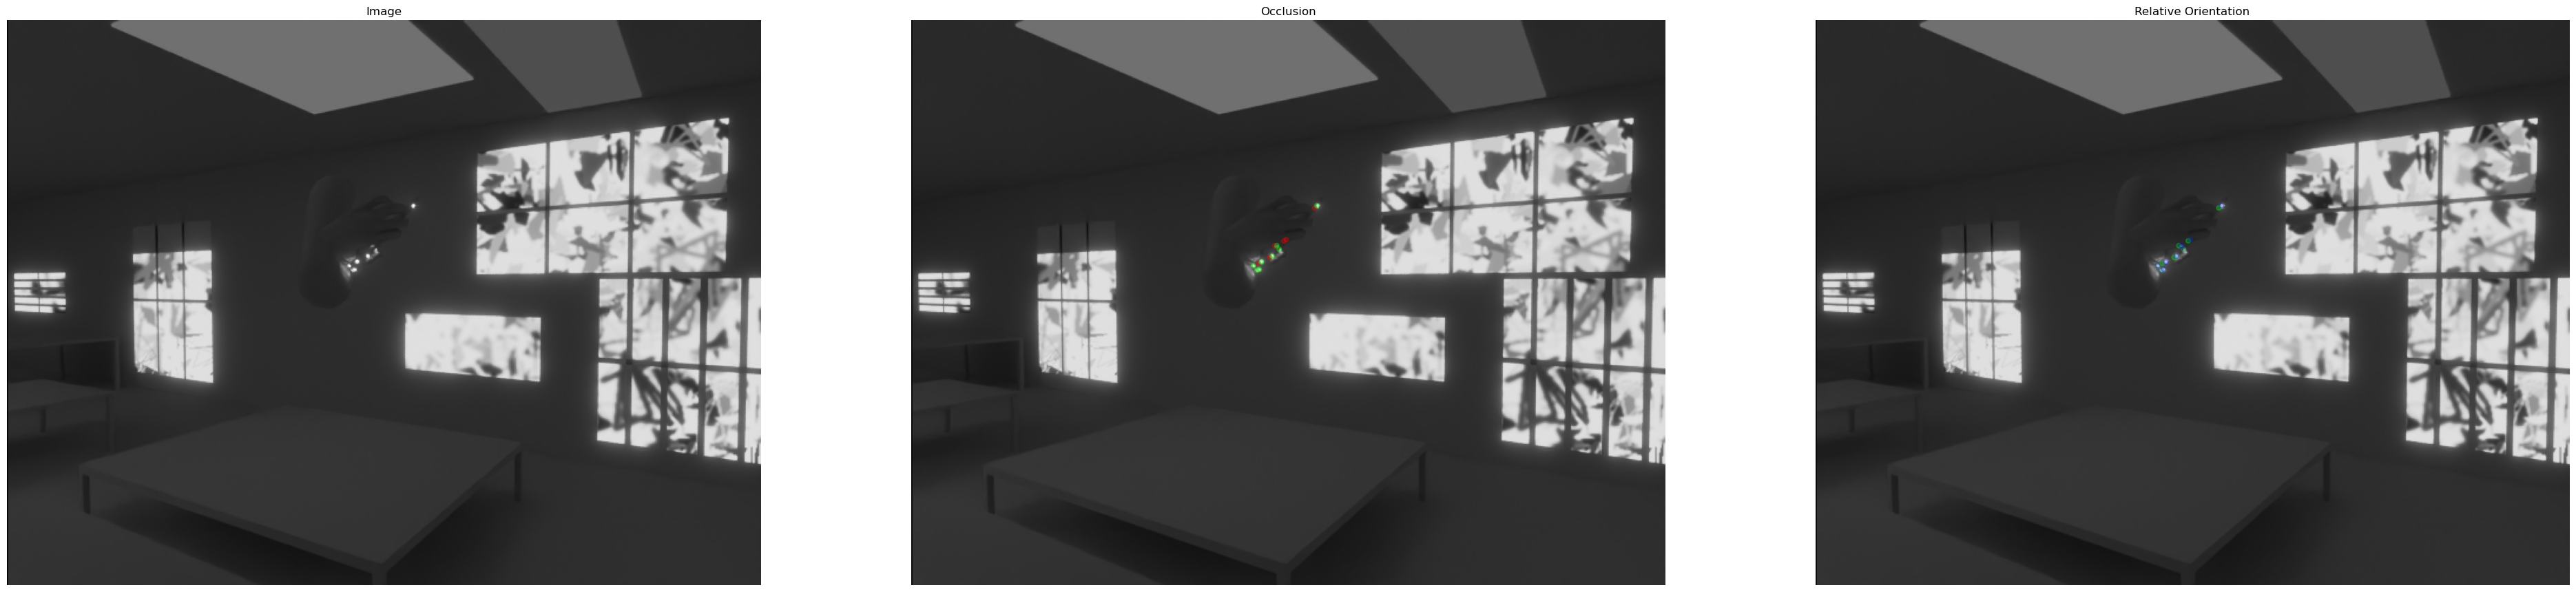

In [4]:
show_led_locations("2", 99)

In [5]:
def data_iterator(show_progress: bool = False):
    """
    Iterates over all data files in the render folder path and yields the data in each file.
    
    Args:
        show_progress: Whether to show a progress bar.
        
    Yields:
        dict: The data in each data file.
    """
    render_folder_paths = os.listdir(RENDER_FOLDER_PATH)

    if show_progress:
        bar = tqdm(render_folder_paths, total=len(render_folder_paths), desc="Iterating over render folders")

    for render_folder_path in render_folder_paths:
        data_file_path = os.path.join(RENDER_FOLDER_PATH, render_folder_path, "data.json")

        if not os.path.exists(data_file_path):
            print(f"Data file not found for render folder {render_folder_path}.")
            continue

        with open(data_file_path, "r") as f:
            data = json.load(f)
            yield data

        if show_progress:
            bar.update(1)

    if show_progress:
        bar.close()

def frame_data_iterator(show_progress: bool = False):
    """
    Iterates over all frame data in the data files and yields the frame data in each file.
    
    Args:
        show_progress: Whether to show a progress bar.
        
    Yields:
        dict: The frame data in each data file.
    """
    for data in data_iterator(show_progress=show_progress):
        for frame_data in data.values():
            yield frame_data

def led_data_iterator(show_progress=False):
    """
    Iterates over all LED data in the frame data and yields the LED data in each frame.
    
    Args:
        show_progress: Whether to show a progress bar.
        
    Yields:
        dict: The LED data in each frame.
    """
    for frame_data in frame_data_iterator(show_progress=show_progress):
        for led_data in frame_data.values():
            yield led_data

Iterating over render folders:   0%|          | 0/1266 [00:00<?, ?it/s]

Iterating over render folders: 100%|██████████| 1266/1266 [00:10<00:00, 124.22it/s]


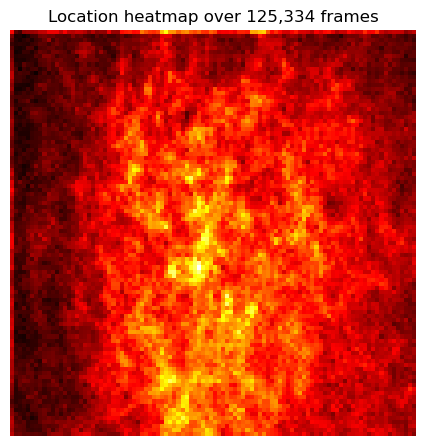

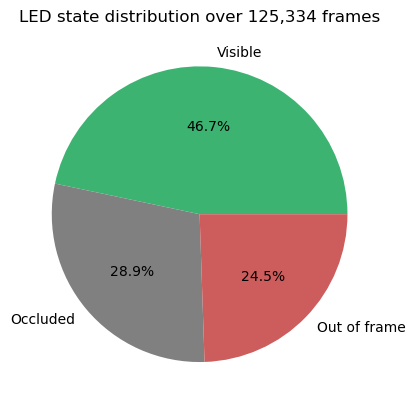

In [6]:
location_heatmap = np.zeros((HEATMAP_WIDTH, HEATMAP_HEIGHT))
n_visible_leds = 0
n_occluded_leds = 0
n_out_of_frame_leds = 0
n_total_leds = 0
n_frames = 0
for led_data in led_data_iterator(show_progress=True):
    u = int(led_data["u"])
    v = int(led_data["v"])
    x = int(led_data["u"] * HEATMAP_WIDTH)
    y = int(led_data["v"] * HEATMAP_HEIGHT)
    occluded = led_data["is_occluded"]

    out_of_frame = u < 0 or u >= 1 or v < 0 or v >= 1

    if not out_of_frame:
        location_heatmap[y, x] += 1
    n_occluded_leds += int(occluded and not out_of_frame)
    n_visible_leds += int(not occluded and not out_of_frame)
    n_out_of_frame_leds += int(out_of_frame)
    n_total_leds += 1

percentage_visible_leds = n_visible_leds / n_total_leds * 100
percentage_occluded_leds = n_occluded_leds / n_total_leds * 100
percentage_out_of_frame_leds = n_out_of_frame_leds / n_total_leds * 100

n_frames = sum(1 for _ in frame_data_iterator())

# Location heatmap
plt.figure()
plt.title(f"Location heatmap over {n_frames:,} frames")
plt.imshow(location_heatmap, cmap="hot", interpolation="nearest")
plt.tight_layout()
plt.axis("off")
plt.show()

# LED type pie chart
plt.figure()
plt.title(f"LED state distribution over {n_frames:,} frames")
plt.pie([n_visible_leds, n_occluded_leds, n_out_of_frame_leds], labels=["Visible", "Occluded", "Out of frame"], autopct="%1.1f%%", colors=["mediumseagreen", "gray", "indianred"])
plt.show()
            

Iterating over render folders: 100%|██████████| 1266/1266 [00:07<00:00, 160.96it/s]


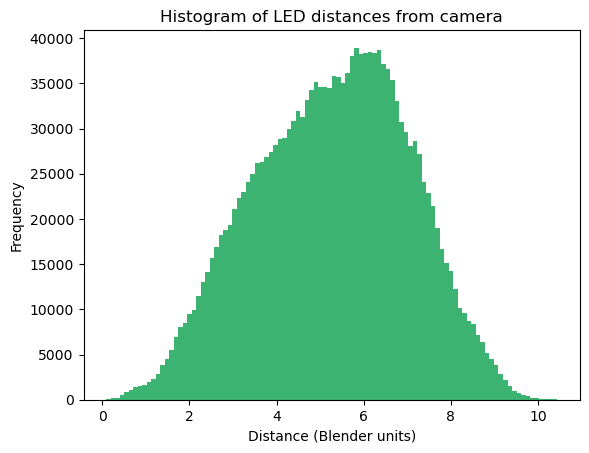

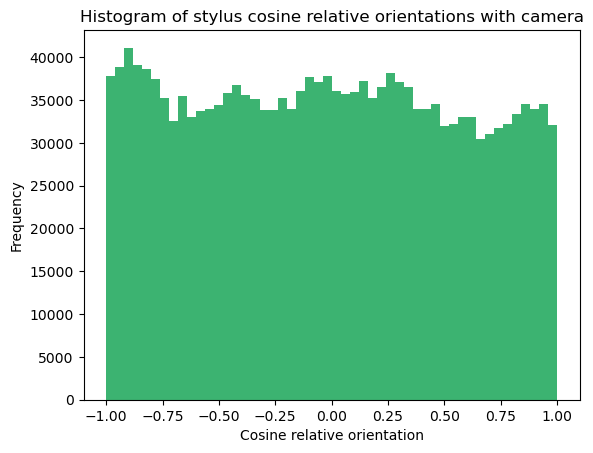

In [7]:
distances = []
stylus_relative_orientations = []
for led_data in led_data_iterator(show_progress=True):
    distance_from_camera = led_data["distance_from_camera"]
    stylus_relative_orientation = led_data["stylus_relative_orientation"]
    distances.append(distance_from_camera)
    stylus_relative_orientations.append(stylus_relative_orientation)

# Distance histogram
plt.figure()
plt.hist(distances, bins=100, color="mediumseagreen")
plt.title("Histogram of LED distances from camera")
plt.xlabel("Distance (Blender units)")
plt.ylabel("Frequency")
plt.show()

# Stylus relative orientation histogram
plt.figure()
plt.hist(stylus_relative_orientations, bins=50, color="mediumseagreen")
plt.title("Histogram of stylus cosine relative orientations with camera")
plt.xlabel("Cosine relative orientation")
plt.ylabel("Frequency")
plt.show()

Iterating over render folders: 100%|██████████| 1266/1266 [00:14<00:00, 88.31it/s]


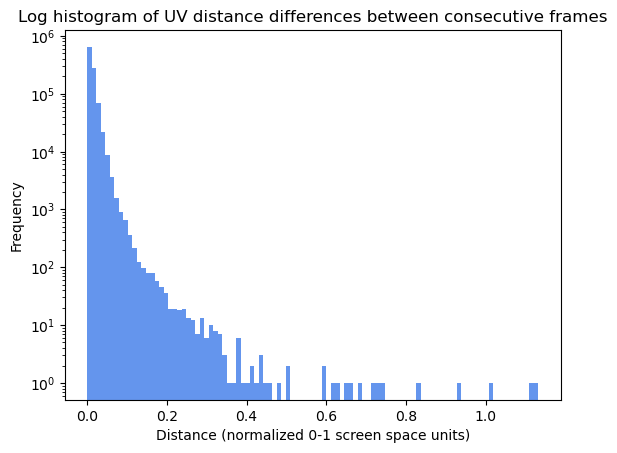

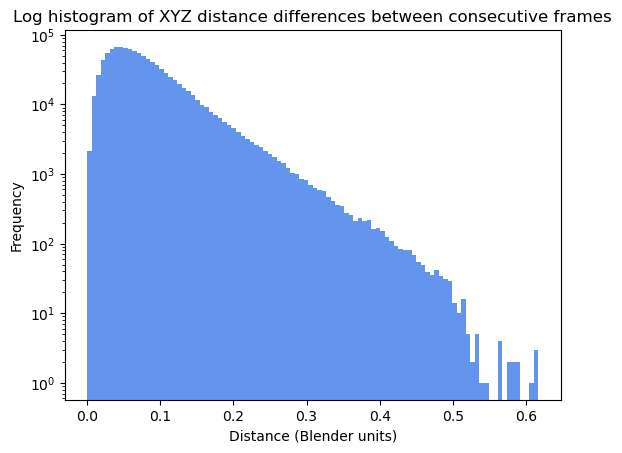

In [8]:
uv_distance_diffs = []
xyz_distance_diffs = []
for data in data_iterator(show_progress=True):
    previous_frame_data = None
    for frame_data in data.values():
        if previous_frame_data is None:
            previous_frame_data = frame_data
            continue

        for led_id, led_data in frame_data.items():
            previous_led_data = previous_frame_data[led_id]
            u, prev_u = led_data["u"], previous_led_data["u"]
            v, prev_v = led_data["v"], previous_led_data["v"]
            x, prev_x = led_data["x"], previous_led_data["x"]
            y, prev_y = led_data["y"], previous_led_data["y"]
            z, prev_z = led_data["z"], previous_led_data["z"]

            if u < 0 or u >= 1 or v < 0 or v >= 1:
                continue

            uv_distance_diff = np.linalg.norm([u - prev_u, v - prev_v])
            xyz_distance_diff = np.linalg.norm([x - prev_x, y - prev_y, z - prev_z])
            uv_distance_diffs.append(uv_distance_diff)
            xyz_distance_diffs.append(xyz_distance_diff)

        previous_frame_data = frame_data

# UV distance histogram
plt.figure()
plt.hist(uv_distance_diffs, bins=100, color="cornflowerblue")
plt.title("Log histogram of UV distance differences between consecutive frames")
plt.xlabel("Distance (normalized 0-1 screen space units)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

# XYZ distance histogram
plt.figure()
plt.hist(xyz_distance_diffs, bins=100, color="cornflowerblue")
plt.title("Log histogram of XYZ distance differences between consecutive frames")
plt.xlabel("Distance (Blender units)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()